refer:
* CVPR09 best http://mmlab.ie.cuhk.edu.hk/archive/2011/Haze.pdf
* performance improvement: matting -> http://kaiminghe.com/publications/pami12guidedfilter.pdf

In [1]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from skimage import measure

#show after imgshow
# %matplotlib inline 

plt.rcParams['figure.figsize'] = (20, 12)

In [49]:
def intensity(pix):
    return sum([i**2 for i in pix])

def get_A(labels, img):
    max_pos, maxv = None, 0.0
    for x,y in zip(*labels.nonzero()):
        inty = intensity(img[x,y])
        if inty > maxv:
            max_pos, maxv = (x,y), inty
    if not max_pos:  # not found
        max_pos = (x,y)
    return img[max_pos]

def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    return arr

### find dark channel (5):
for un-hazed image:
$$J^{dark}(\mathbf{x}) = \min \limits_{\mathbf{y} \in \Omega(\mathbf{x})}\left( \min \limits_{c \in \{r,b,g\}}    J^c（\mathbf{y}）\right)$$

### estimate A(Atmospheric light):

* pick top 0.1% brightest pixels in the dark channel
* among the pixels, find pixel with highest intensity in the input image I 

### estimate transmission (12):

$$ \tilde{t}(\mathbf{x}) = 1  - \omega \min \limits_{c} \left( \min \limits_{\mathbf{y} \in \Omega(\mathbf{x})} \frac{\mathbf{I}^c(\mathbf{y})}{A^c} \right) $$
    
let $\omega = 0.95$

### recover J(scene radiance) (16):
$$ J(\mathbf{x}) = \frac{\mathbf{I}(\mathbf{x}) - \mathbf{A}}{max(t(\mathbf{x}), t_0)} + \mathbf{A}$$
let $t_0 = 0.1$

image shape: (493, 658, 3)
len(min_c):324394, topn: 324
threshold: 0.780392
A: [ 0.9137255   0.90980393  0.96470588]


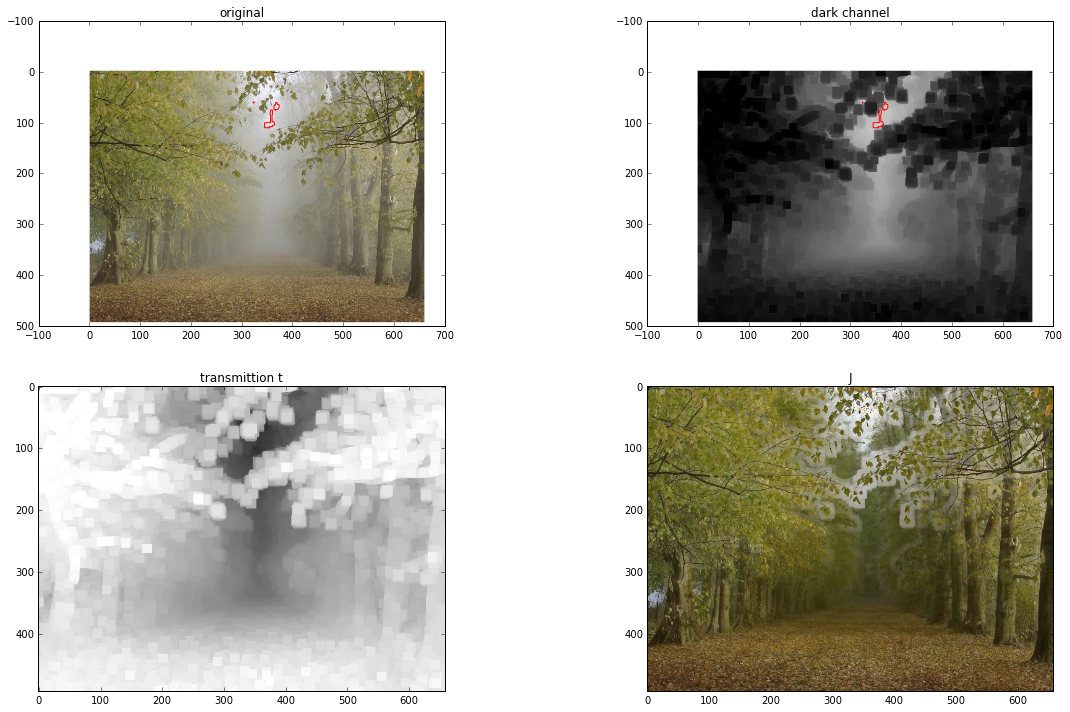

In [63]:
import os
patch_size=15
omega = 0.95
t0 = 0.1

# moutain with clouds
#url = 'http://images.cnitblog.com/blog/349293/201308/23182251-54b62c3d9ce040f8a454ff02d8c92740.x-png'
#url = 'http://images.cnitblog.com/blog/349293/201308/23182911-bcc7901924274e278be1c4b7e639fe13.x-png'
#url='http://images.cnitblog.com/blog/349293/201308/23145513-357ba73488b0430cbcd93cd7781c4ae9.x-png'
url = os.getenv('HOME') + '/bak/woods.jpg'

img = mpimg.imread(url)   # (r,g,b) normalized to (0~1.0)
print 'image shape:', img.shape

img = normalize(img)
#Plot figure and two regions
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(img)
axs[0,0].set_title('original')

# fast algrithm of finding local min of patch_size
#data_min = ndimage.filters.minimum_filter(img, (patch_size, patch_size, 1)) # channel wise
J_dark = ndimage.filters.minimum_filter(img, patch_size) 
axs[0,1].imshow(J_dark)
axs[0,1].set_title('dark channel')

# statistic of dark channel prior
min_c = J_dark[:,:,0]
# omit show
#axs[1,0].hist(min_c.reshape(-1,1))
#axs[1,0].set_title('dark channel prior static')

lst = sorted(min_c.flat, reverse=True)
topn = max(1, int(len(lst) * 1e-3))
print 'len(min_c):%d, topn: %d' %(len(lst), topn)
threshold = lst[topn]
print 'threshold:', threshold 

labels, num_labels = ndimage.measurements.label(min_c > threshold)
assert labels.sum() > 0 
#np.nonzero(labels)
contours = measure.find_contours(labels, 0)

for n, contour in enumerate(contours):
    for ax in (axs[0,0], axs[0,1]):
        ax.plot(contour[:,1], contour[:, 0], color='r', linewidth=1)

A = get_A(labels, img)
A = np.array(A, dtype=np.float32)

print 'A:', A
min_c2 = ndimage.filters.minimum_filter(img, (patch_size, patch_size, 1))/A
min_3 = np.min(min_c2, axis=2)

for (x,y), v in np.ndenumerate(min_3):
    for k in range(3):
        min_c2[x,y, k] = v    
t = 1 - omega * min_c2
axs[1,0].imshow(t)
axs[1,0].set_title('transmittion t')

J = np.subtract(np.array(img, dtype=np.float32), A)/np.maximum(t, t0) + A
axs[1,1].imshow(J)
axs[1,1].set_title('J')

plt.show()

#fig.savefig('result.png')